In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from bs4 import BeautifulSoup
import requests
import json
import time

In [4]:
base_url = "https://www.racingchannel.com"
text = requests.get(base_url+"/results_archive.php").text
soup = BeautifulSoup(text, "html.parser")
table = soup.find("div", attrs={"class": "AccordionPanelContent"}).find_all("a")

In [5]:
locations = [url.get_text() for url in table] # get location text for each anchored element in table
# clean typos in original table
locations[1] = unicode("Arlington Park")
locations[34] = unicode("Indiana Downs")
loc_urls = [url.get("href") for url in table] # get url for each anchored element in table

In [6]:
%%time
date_dict = {}
for loc, loc_url in zip(locations, loc_urls):
    r1 = requests.get(base_url+loc_url).text
    s1 = BeautifulSoup(r1, "html.parser")
    cols = s1.find_all("td", attrs={"valign": "top"})
    links = []
    date_format = []
    dates = []
    for col in cols:
        months = col.find_all("a")
        for month in months:
            links.append(month.get("href"))
    for link in links:
        r2 = requests.get(base_url+link).text
        s2 = BeautifulSoup(r2, "html.parser")
        cal_urls = s2.find("table", attrs={"width": "567"}).find_all("a")
        for cal_url in cal_urls:
            dates.append(cal_url.get('href'))
        time.sleep(2)
    import re # http://regexr.com
    for item in dates:
        l = re.findall("(?:\d*\.)?\d+", item)
        date_format.append(l[0] + l[1] + l[2][4:])
    date_dict[loc] = date_format

CPU times: user 3min 39s, sys: 11.8 s, total: 3min 51s
Wall time: 4h 23min 23s


In [ ]:
traindf.loc[traindf[isinstance(traindf.name, float)]]

In [129]:
#date_dict

In [128]:
#locations

In [6]:
zips = ['11420', '60005', 'NA', 'NA', 'NA', '94403', '11003', '43123', '33056', '00729', '55379', '25438',
        '40208', '23124', '70668', '92014', '19804', '42420', '98001', '70570', '70119', '62234', '91768', 
        '14425', 'NA', '94710', 'NA', 'NA', '49415', '33009', 'NA', '60804', '90305', '46013', '46176', '40510', 
        '42134', '20725', '71111', '75050', '90720', '07073', '07757', '26047', 'NA', '71901', '17028', 
        '19020', '21215', '97217', '50009', '73111', '78154', '45230', '77064', '91007', '12866', 'NA', 
        'NA', '60804', '02128', '33626', '44128', '21093', '85023', '41042', 'NA'] 

In [7]:
zips_dict = dict(zip(locations, zips))

In [126]:
#zips_dict

In [147]:
##############
# START HERE #
##############

In [68]:
date = '20141225'
zip_code = '11420'
wunderground_url = 'http://api.wunderground.com/api/4a26cfc369eb7841/history_{}/q/{}.json'.format(date, zip_code)

In [69]:
examp = json.loads(requests.get(wunderground_url).text)

In [201]:
weather_data = ['fog','hail','maxhumidity','meandewptm','meanpressurem','meantempm','meanvism',
                'meanwdird', 'meanwindspdm', 'precipm', 'rain', 'snow', 'snowdepthm','snowfallm', 'thunder',
                'minhumidity']

In [183]:
# function to format data returned from wunderground api to have only the metrics we want
def output_dict(in_dict):
    temp = [(elem,in_dict[elem]) for elem in in_dict.keys() if elem in weather_data]
    return dict(temp)

In [202]:
output_dict(examp['history']['dailysummary'][0])

{u'fog': u'1',
 u'hail': u'0',
 u'maxhumidity': u'96',
 u'meandewptm': u'3',
 u'meanpressurem': u'1008',
 u'meantempm': u'10',
 u'meanvism': u'13',
 u'meanwdird': u'261',
 u'meanwindspdm': u'27',
 u'minhumidity': u'35',
 u'precipm': u'1.52',
 u'rain': u'1',
 u'snow': u'0',
 u'snowdepthm': u'0.00',
 u'snowfallm': u'0.00',
 u'thunder': u'0'}

In [77]:
# read in JPaul's dates data frame
datesdf = pd.read_csv("tempdata/usadays.csv")
datesdf.drop('track.1',axis=1, inplace=True)
datesdf.head()

,track,year,month,day
0,AQU,1998,10,28
1,AQU,1998,10,29
2,AQU,1998,10,30
3,AQU,1998,10,31
4,AQU,1998,11,1


In [103]:
# convert date components to strings and add a 0 before single digit month/days
datesdf[['year', 'month', 'day']] = datesdf[['year', 'month', 'day']].astype(str)
for line in datesdf.index:
    if len(datesdf.loc[line]['month']) == 1:
        datesdf.loc[line]['month'] = '0' + datesdf.loc[line]['month']
    if len(datesdf.loc[line]['day']) == 1:
        datesdf.loc[line]['day'] = '0' + datesdf.loc[line]['day']
datesdf.head()

,track,year,month,day
0,AQU,1998,10,28
1,AQU,1998,10,29
2,AQU,1998,10,30
3,AQU,1998,10,31
4,AQU,1998,11,01


In [108]:
# dictionary keyed by track to store corresponding date strings
# stores all dates on which races occurred for a given track identifier
dates_dict = {}
for track in datesdf.track.unique():
    datestring = []
    for row in datesdf.index:
        if datesdf.iloc[row]['track'] == track:
            datestring.append(str(datesdf.iloc[row]['year']) + str(datesdf.iloc[row]['month']) + str(datesdf.iloc[row]['day']))
    dates_dict[track] = datestring 

In [213]:
# zipcodes for all U.S. tracks
# obtained by manual lookup, arranged in alphabetical order (according to 3 letter track identifier)
zips1 = ['11420', '60005','94403', '11003', '43123', '33056', '55379','40208', '23124', '25438', '70668', 
         '92014', '19804', '42420', '98001', '70570', '70119', '14425', '91768', '62234', '49415', '94710', 
         '33009', '60804', '46013', '90305', '46176', '40510', '42134', '20725', '71111', '75050', '90720', 
         '07073', '07757', '26047', '71901', '85023', '17028', '19020', '21215', '50009', '73111', '78154', 
         '45230', '77064', '91007', '12866', '60804', '02128', '33626', '44128', '21093', '41042']
locs = datesdf.track.unique()
# dictionary mapping track identifiers to zipcodes
zips_dict1 = dict(zip(locs, zips1))

In [227]:
# queries wunderground API for every track-date combination
# stores results in dictionary keyed by (track id, date) tuple
%%time
weather_dict = {}
except_list = []
for key in dates_dict.keys():
    for fdate in dates_dict[key]:
        wunderground_url = 'http://api.wunderground.com/api/4a26cfc369eb7841/history_{}/q/{}.json'.format(fdate, zips_dict1[key])
        try:
            temp = json.loads(requests.get(wunderground_url).text)['history']['dailysummary'][0]
            weather_dict[(key, fdate)] = output_dict(temp)
        except:
            except_list.append(zip(key,fdate))

CPU times: user 8min 30s, sys: 59.9 s, total: 9min 30s
Wall time: 14h 21min 51s


In [255]:
# converts output to a dataframe
bigdf = []
for tup in weather_dict.keys():
    stuff = [tup[0],tup[1]]
    for key in sorted(weather_dict[tup].keys()):
        stuff.append(weather_dict[tup][key])
    bigdf.append(stuff)
weather_df = pd.DataFrame(bigdf, columns = ['track', 'date'] + sorted(weather_dict[weather_dict.keys()[0]].keys()))
weather_df

,track,date,fog,hail,maxhumidity,meandewptm,meanpressurem,meantempm,meanvism,meanwdird,meanwindspdm,minhumidity,precipm,rain,snow,snowdepthm,snowfallm,thunder
0,REM,20040925,0,0,94,12,1021,21,11,13,8,23,0.00,0,0,,0.00,0
1,DPK,20130612,0,0,87,17,1010,24,16,299,14,47,0.00,0,0,0.00,0.00,0
2,FMT,20130601,0,0,94,17,1009,22,15,182,10,61,12.95,1,0,,0.00,1
3,PAR,20050225,0,0,80,6,1012,13,16,30,8,38,0.00,0,0,,0.00,0
4,BEU,20130504,0,0,66,6,1017,17,16,101,16,40,0.00,0,0,,0.00,0
5,AQU,20061231,0,0,70,-3,1030,4,16,222,15,44,0.00,0,0,0.00,0.00,0
6,BEL,20110615,0,0,80,11,1011,21,16,331,13,25,T,1,0,0.00,0.00,0
7,TUR,20011214,0,0,100,8,1009,10,8,194,19,69,9.14,1,0,,0.00,0
8,ARL,20060830,0,0,93,16,1018,19,14,30,13,70,0.00,1,0,,0.00,0
9,ARL,20030518,0,0,96,11,1019,14,11,63,11,66,0.00,0,0,,0.00,0


In [231]:
#weather_df.to_csv('tempdata/weather.csv')

In [374]:
weather_df = pd.read_csv("tempdata/weather.csv", index_col=0)
weather_df.head()

,track,date,fog,hail,maxhumidity,meandewptm,meanpressurem,meantempm,meanvism,meanwdird,meanwindspdm,minhumidity,precipm,rain,snow,snowdepthm,snowfallm,thunder
0,REM,20040925,0,0,94,12,1021,21,11,13,8,23,0.00,0,0,NaN,0.00,0
1,DPK,20130612,0,0,87,17,1010,24,16,299,14,47,0.00,0,0,0.00,0.00,0
2,FMT,20130601,0,0,94,17,1009,22,15,182,10,61,12.95,1,0,NaN,0.00,1
3,PAR,20050225,0,0,80,6,1012,13,16,30,8,38,0.00,0,0,NaN,0.00,0
4,BEU,20130504,0,0,66,6,1017,17,16,101,16,40,0.00,0,0,NaN,0.00,0


In [375]:
import datetime
weather_df.date = weather_df.date.apply(lambda x: datetime.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [376]:
weather_df.precipm.loc[weather_df.precipm =="T"] = np.nan
weather_df.snowdepthm.loc[weather_df.snowdepthm == "T"] = np.nan
weather_df.snowfallm.loc[weather_df.snowfallm == "T"] = np.nan
for col in weather_df.iloc[:,2:]:
    weather_df[col] = weather_df[col].astype(float)
weather_df.head()

,track,date,fog,hail,maxhumidity,meandewptm,meanpressurem,meantempm,meanvism,meanwdird,meanwindspdm,minhumidity,precipm,rain,snow,snowdepthm,snowfallm,thunder
0,REM,2004-09-25,0,0,94,12,1021,21,11,13,8,23,0.00,0,0,NaN,0,0
1,DPK,2013-06-12,0,0,87,17,1010,24,16,299,14,47,0.00,0,0,0,0,0
2,FMT,2013-06-01,0,0,94,17,1009,22,15,182,10,61,12.95,1,0,NaN,0,1
3,PAR,2005-02-25,0,0,80,6,1012,13,16,30,8,38,0.00,0,0,NaN,0,0
4,BEU,2013-05-04,0,0,66,6,1017,17,16,101,16,40,0.00,0,0,NaN,0,0


In [377]:
weather_df.to_csv('tempdata/weather.csv')

NameError: name 'weather_df1' is not defined

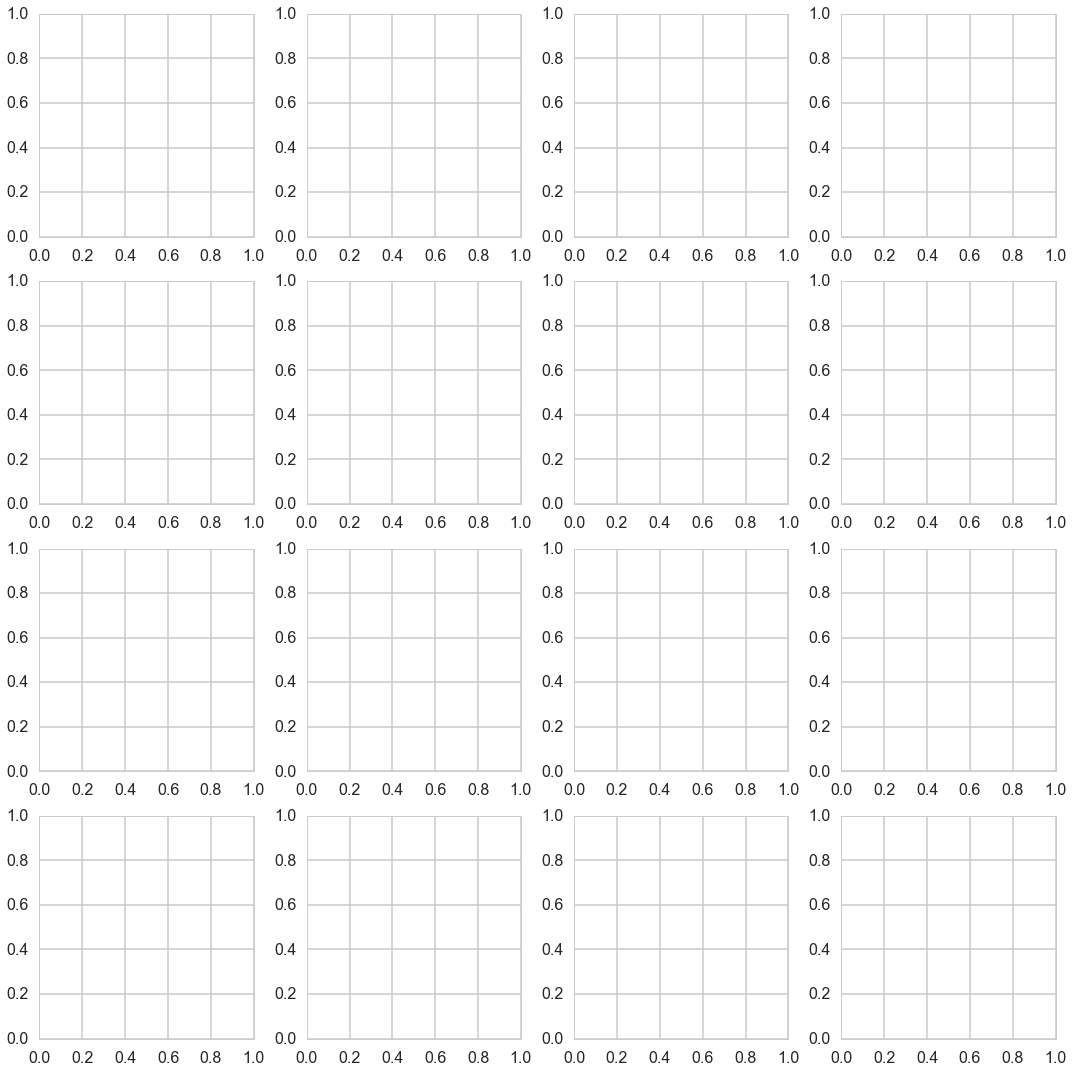

In [396]:
f1, ax1 = plt.subplots(4,4, figsize=(15,15), tight_layout=True)
for j, col in enumerate(weather_df1.columns[2:]):
    axis = ax1[j / 4][j % 4] # iterator to loop through plots
    # plot histogram for each indicator variable, separating each bar by response status
    axis.hist(weather_df1[col].dropna(), alpha=.5, color='b')
    axis.set_title(weather_df1[col].name)
    axis.legend()

In [3]:
pages = {}
years1 = [str(i) for i in range(1998,2016)]
years2 = [str(i) for i in range(2006,2016)]
track_year_dict = {"_Kentucky_Derby": years1, "_Preakness_Stakes": years1, "_Belmont_Stakes": years2}

for key in track_year_dict.keys():
    for year in track_year_dict[key]:
        pages[year+key] = requests.get("https://en.wikipedia.org/wiki/{}".format(year+key)).text
        time.sleep(0.1)

In [4]:
# function to parse scraping output
# returns 2 data frames, one for payouts and one for results for a given race in a given year
def parser(key, page_dict):
    soup = BeautifulSoup(page_dict[key], "html.parser")
    tables = soup.find_all("table", attrs={"class": "wikitable"})
    
    if len(tables[0].find_all("tr")) <= 5:
        table1 = tables[0].find_all("tr")
        table2 = tables[1].find_all("tr")
    else:
        table1 = tables[1].find_all("tr")
        table2 = tables[0].find_all("tr")
    
    t1headers = [elem.get_text() for elem in table1[0].find_all("th")]
    t2headers = [elem.get_text() for elem in table2[0].find_all("th")]
    if (key == "2005_Kentucky_Derby"):
        t2headers.append("Time")
        t2headers[t2headers.index("Jockey")] = "Horse"
    
    t1 = []
    t2 = []
    for row1 in table1[1:]:
        r1_data = [cell.get_text() for cell in row1.find_all("td")]
        t1.append(r1_data)
    for row2 in table2[1:]:
        # handles cases where cells in horse column all have header tags
        if row2.find("th"):
            r2_data = [cell.get_text() for cell in row2.find_all("td")]
            r2_data.insert(2, row2.find("th").get_text())
            t2.append(r2_data)
        else:
            r2_data = [cell.get_text() for cell in row2.find_all("td")]
            t2.append(r2_data)       
    try:
        payout = pd.DataFrame(t1, columns=t1headers)
        results = pd.DataFrame(t2, columns=t2headers)
    except Exception,e:
        # handles 2015 Kentucky Derby results table, which doesn't have a header row
        if key == "2015_Kentucky_Derby":
            t1headers = [elem.get_text() for elem in table1[0].find_all("td")]
            payout = pd.DataFrame(t1, columns=t1headers)
            results = pd.DataFrame(t2, columns=t2headers)
        else:
            print str(e)
  
    return (payout, results)

In [309]:
# dictionary of data frames keyed by track-year string
# values are tuples of data frames returned by parser
bigdict = {key:parser(key, pages) for key in pages.keys()}

In [310]:
# constructs single payouts data frame by concatenating all payout data frames contained in bigdict
payouts_df = pd.DataFrame(columns=["Post", "Horse", "Win", "Place", "Show", "Track", "Year"])
for track in track_year_dict.keys():
    for year in track_year_dict[track]:
        access = year+track
        bigdict[access][0].columns = ["Post", "Horse", "Win", "Place", "Show"]
        bigdict[access][0]["Track"] = track
        bigdict[access][0]["Year"] = year
        payouts_df = pd.concat([payouts_df, bigdict[access][0]], ignore_index = True)

In [311]:
def dollar_clean(inpt):
    try:
        if "$" in inpt:
            a = inpt.split("$")
            a = a[1]
            if " " in a:
                b = a.split(" ")
                c = b[1]
                return float(c)
            else:
                return float(a)
        else:
            return float(inpt)
    except:
        return inpt

In [312]:
payouts_df.replace("-", np.nan, inplace=True)
payouts_df.replace(u"\u2013", np.nan, inplace=True)
payouts_df.replace("", np.nan, inplace=True)
payouts_df.Post = payouts_df.Post.apply(clean_post)

In [313]:
payouts_df.Win = payouts_df.Win.apply(dollar_clean)
payouts_df.Place = payouts_df.Place.apply(dollar_clean)
payouts_df.Show = payouts_df.Show.apply(dollar_clean)
payouts_df

,Post,Horse,Win,Place,Show,Track,Year
0,11,Real Quiet,7.0,3.6,3.0,_Preakness_Stakes,1998
1,10,Victory Gallop,NaN,3.2,2.8,_Preakness_Stakes,1998
2,3,Classic Cat,NaN,NaN,4.8,_Preakness_Stakes,1998
3,6,Charismatic,18.8,7.6,5.8,_Preakness_Stakes,1999
4,5,Menifee,NaN,3.6,3.2,_Preakness_Stakes,1999
5,4,Badge,NaN,NaN,18.8,_Preakness_Stakes,1999
6,4,Red Bullet,14.4,3.2,2.8,_Preakness_Stakes,2000
7,7,Fusaichi Pegasus,NaN,2.6,2.2,_Preakness_Stakes,2000
8,3,Impeachment,NaN,NaN,3.6,_Preakness_Stakes,2000
9,11,Point Given,6.6,5.0,4.0,_Preakness_Stakes,2001


In [14]:
def any_in(my_list, comp_list):
    ret_list = []
    for item in my_list:
        if item in comp_list:
            ret_list.append(item)
    return ret_list

def dropper(df, my_list):
    drops = any_in(my_list, df.columns)
    df.drop(drops, axis=1, inplace=True)
    return df

def renamer(df, old_names, new_name):
    if any_in(old_names, df.columns):
        rename = any_in(old_names, df.columns)[0]
        newcolnms = list(df.columns)
        index = newcolnms.index(rename)
        newcolnms[index] = new_name
        df.columns = newcolnms
    
    
drop_list = ["Trainer", "Jockey", "Owner", "Lengths\nBehind", "Time / behind", "Time/\nBehind", 
             "Trainer\n\n", "Points[7]", "Points", "Previous Race", "Time"]
Horse = ["Horse name"]
Finish = ["Finish\nPosition", "Finish[2]", "Results", "Finished", "Position", "Finish\nposition", "Finish"]
Post = ["Post\nPosition", "Number", "Program\nNumber", "Post\nposition", "Pgm", "Post"]
Stakes = ["Stake", "Purse\nEarnings", "Stakes"]
MOdds = ["Morning Line\nOdds", "Morning\nline\nodds", "Opening odds (to 1)", "Opening Odds", "Morning\nodds[3]",
        "Morning Line Odds", "Morning Line\nodds", "Morning\nOdds[3]", "Opening\nOdds"]
POdds = ["Final\nodds[1]", "Post Time\nOdds", "Final odds[4]", "Post Time\nodds", "Final Odds", "Final Odds[2]",
        "Final odds", "Final odds\nto $1[1]", "Odds"]

for k in bigdict.keys():
    dropper(bigdict[k][1], drop_list)
    renamer(bigdict[k][1], Horse, "Horse")
    renamer(bigdict[k][1], Finish, "Finish")
    renamer(bigdict[k][1], Post, "Post")
    renamer(bigdict[k][1], Stakes, "Stakes")
    renamer(bigdict[k][1], MOdds, "Morning Line Odds")
    renamer(bigdict[k][1], POdds, "Post Time Odds")

In [15]:
results_df = pd.DataFrame(columns=["Track", "Year", "Finish", "Post", "Horse", "Morning Line Odds", "Post Time Odds", "Stakes"])
for track in track_year_dict.keys():
    for year in track_year_dict[track]:
        access = year+track
        bigdict[access][1]['Track'] = track
        bigdict[access][1]['Year'] = year
        results_df = pd.concat([results_df, bigdict[access][1]], ignore_index = True)

In [16]:
for c in ["Morning Line Odds", "Post Time Odds"]:
    for i in results_df.loc[(results_df.Track == "_Belmont_Stakes")&(results_df.Year == "2015")].index:
        results_df[c].iloc[i] = results_df[c].iloc[i][20:]

In [17]:
# http://stackoverflow.com/questions/19124601/is-there-a-way-to-pretty-print-the-entire-pandas-series-dataframe
pd.set_option('display.max_rows', len(results_df))
# pd.reset_option('display.max_rows')
results_df

,Finish,Horse,Morning Line Odds,Post,Post Time Odds,Stakes,Track,Year
0,1st,Real Quiet,NaN,11,2.50-1,"$650,000",_Preakness_Stakes,1998
1,2nd,Victory Gallop,NaN,10,2.00-1\nfavorite,"$200,000",_Preakness_Stakes,1998
2,3rd,Classic Cat,NaN,3,12.30-1,"$100,000",_Preakness_Stakes,1998
3,4th,Hot Wells,NaN,7,25.20-1,"$50,000",_Preakness_Stakes,1998
4,5th,Black Cash,NaN,2,7.10-1,,_Preakness_Stakes,1998
5,6th,Spartan Cat,NaN,1,98.80-1,,_Preakness_Stakes,1998
6,7th,Baquero,NaN,6,14.60-1,,_Preakness_Stakes,1998
7,8th,Basic Trainee,NaN,5,63.80-1,,_Preakness_Stakes,1998
8,9th,Cape Town,NaN,4,2.90-1,,_Preakness_Stakes,1998
9,10th,Silver's Prospect,NaN,8,98.00-1,,_Preakness_Stakes,1998


In [238]:
# http://stackoverflow.com/questions/944700/how-to-check-for-nan-in-python
def isNaN(num):
    return num != num

def make_odds(item):
    try:
        if (item == "scr") or (item == "Scr") or (item == "SCR") or (item == "DNR"):
            return 0
        elif " !" in item: 
            return float(item[0:4])
        
        q = item.split(u'\u2660')
        if len(q) > 1:
            q = q[1]
        else:
            q = q[0]
        
        y = q.split("\n")
        if "-" in y[0]: 
            x = y[0].split("-")
        elif u"\u2014" in y[0]:
            x = y[0].split(u"\u2014")
        if len(x) > 1:
            return float(x[0])/float(x[1])
        else:
            
            return float(a[0])
    except Exception, e:
        return item

def clean_finish(inpt):
    if not isinstance(inpt, int):
        if len(inpt) > 2 and inpt[:-2].isdigit():
            return int(inpt[:-2])
        elif inpt.isdigit():
            return int(inpt)
        else:
            return 0
    else:
        return inpt
    
def clean_post(inpt):
    try:
        return int(inpt)
    except:
        return 0

In [ ]:
smallresults_df = results_df[["Finish", "Post", "Horse", "Morning Line Odds", "Post Time Odds", "Track", "Year"]]
smallresults_df["Odds"] = np.nan
for num in smallresults_df.index:
    if not isNaN(smallresults_df["Morning Line Odds"].iloc[num]):
        smallresults_df["Odds"].iloc[num] = smallresults_df["Morning Line Odds"].iloc[num]
    else:
        smallresults_df["Odds"].iloc[num] = smallresults_df["Post Time Odds"].iloc[num]
smallresults_df.drop(["Morning Line Odds", "Post Time Odds"], axis=1, inplace=True)
smallresults_df["Odds2"] = smallresults_df.Odds.apply(make_odds)
smallresults_df

In [168]:
#smallresults_df.to_csv('tempdata/smallresults.csv', encoding="utf8")

In [297]:
smallresults_clean = pd.read_csv("tempdata/109_OddsDF.csv", index_col=0)
smallresults_clean["Odds"] = smallresults_clean["Odds2"]
smallresults_clean.drop("Odds2", axis=1, inplace=True)
smallresults_clean = smallresults_clean.reset_index()
smallresults_clean.drop("index", axis=1, inplace=True)
smallresults_clean.Horse.iloc[190] = smallresults_clean.Horse.iloc[190][:-3]
smallresults_clean.Post.iloc[528:540] = [8,9,2,11,6,3,1,4,12,5,7,10]
smallresults_clean.Finish.iloc[557:562] = [1,2,3,4,5]
smallresults_clean.Finish.iloc[615:617] = [4,4]
smallresults_clean.Finish = smallresults_clean.Finish.apply(clean_finish)
smallresults_clean.Post = smallresults_clean.Post.apply(clean_post)
smallresults_clean.Year = smallresults_clean.Year.astype(str)

In [299]:
smallresults_clean.to_csv("tempdata/smallresults_clean.csv")

In [298]:
smallresults_clean

,Finish,Post,Horse,Track,Year,Odds
0,1,11,Real Quiet,_Preakness_Stakes,1998,2.50
1,2,10,Victory Gallop,_Preakness_Stakes,1998,2.00
2,3,3,Classic Cat,_Preakness_Stakes,1998,12.30
3,4,7,Hot Wells,_Preakness_Stakes,1998,25.20
4,5,2,Black Cash,_Preakness_Stakes,1998,7.10
5,6,1,Spartan Cat,_Preakness_Stakes,1998,98.80
6,7,6,Baquero,_Preakness_Stakes,1998,14.60
7,8,5,Basic Trainee,_Preakness_Stakes,1998,63.80
8,9,4,Cape Town,_Preakness_Stakes,1998,2.90
9,10,8,Silver's Prospect,_Preakness_Stakes,1998,98.00


In [321]:
result_testdf = pd.merge(payouts_df, smallresults_clean, how="right", on=["Track", "Year", "Horse", "Post"])

In [322]:
result_testdf.to_csv("tempdata/result_testdf.csv")

In [93]:
def get_bets(key, page_dict):
    tsoup = BeautifulSoup(page_dict[key], "html.parser")
    want = tsoup.find_all("ul")
    newtext = []
    for l in range(len(want)):
        try: 
            if want[l].find("li").get_text()[0] == "$":
                text = [item.get_text() for item in want[l].find_all("li") if item.get_text()[0] == "$"]
                newtext = [each.split() for each in text]
            if len(newtext[0]) == 5:
                for each in newtext:
                    try:
                        each.remove("Paid")
                    except:
                        try:
                            each.remove("paid")
                        except:
                            pass           
        except:
            pass
        if newtext:
            df = pd.DataFrame(newtext, columns = ["Base", "Bet Type", "Winning Numbers", "Payout"])
            return df

In [19]:
betsdict = {key:get_bets(key, pages) for key in pages.keys()}

In [20]:
del betsdict["2007_Belmont_Stakes"]
betsdict

{'1998_Kentucky_Derby':   Base     Bet Type Winning Numbers        Payout
 0   $2      Exacta:          (2-12)       $291.80
 1   $2    Trifecta:        (2-12-7)     $1,221.00
 2   $1  Superfecta:      (2-12-7-3)  $3,007.40[2],
 '1998_Preakness_Stakes':   Base     Bet Type Winning Numbers   Payout
 0   $2      Exacta:         (11–10)   $14.80
 1   $2    Trifecta:       (11–10–3)   $97.40
 2   $1  Superfecta:     (11–10–3–8)  $270.80,
 '1999_Kentucky_Derby':   Base     Bet Type Winning Numbers         Payout
 0   $2      Exacta:         (11-13)        $727.80
 1   $2    Trifecta:       (11-13-8)      $5,866.20
 2   $1  Superfecta:     (11-13-8-9)  $24,015.50[3],
 '1999_Preakness_Stakes':   Base     Bet Type Winning Numbers      Payout
 0   $2      Exacta:           (6–5)      $47.60
 1   $2    Trifecta:         (6–5–4)   $2,049.80
 2   $1  Superfecta:      (6–5–4–11)  $18,887.60,
 '2000_Kentucky_Derby':   Base     Bet Type Winning Numbers        Payout
 0   $2      Exacta:          (12-

In [21]:
testbets_df = pd.DataFrame(columns=["Base", "Bet Type", "Winning Numbers", "Payout", "Track", "Year"])
for track in track_year_dict.keys():
    for year in track_year_dict[track]:
        access = year+track
        if access == "2007_Belmont_Stakes":
            pass
        else:
            betsdict[access]["Track"] = track
            betsdict[access]["Year"] = year
            testbets_df = pd.concat([testbets_df, betsdict[access]], ignore_index = True)

In [385]:
testbets_df.to_csv("tempdata/testbets.csv", encoding="utf8")

In [386]:
derby_dates = [19980502, 19990501, 20000506, 20010505, 20020504, 20030503, 20040501, 20050507, 20060506, 20070505, 20080503, 20090502, 20100501, 20110507, 20120505, 20130504, 20140503, 20150502]

In [390]:
func = lambda x: datetime.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:]))
kderby_dates = [func(x) for x in derby_dates]

In [395]:
str(np.nan)

'nan'